In [2]:
import os
import sys
import time
import numpy as np
import pandas as pd
import pysindy as ps
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sysidentpy.utils.display_results import results
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.metrics import root_relative_squared_error, mean_forecast_error

# To have the Matplotlib plots centered in the notebook
from IPython.core.display import HTML
HTML("""
    <style>
    .output_png {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
    }
    </style>
    """)

# To ignore UserWarnings
import warnings
warnings.filterwarnings('ignore')

# Import local function
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('')), 'src'))

from metrics import get_metrics_df
from narmax.utils import display_nx_model

In [3]:
# Rawd data taken from https://github.com/DavidContrerasFranco/Feedback-Systems/blob/main/Covid-19-Model/covid_BaseModel.py
N = 49648685

Real_S = np.array([49648683, 49648682, 49648677, 49648671, 49648666, 49648663, 49648659, 49648650, 49648633, 49648620, \
                   49648606, 49648584, 49648539, 49648500, 49648450, 49648384, 49648283, 49648136, 49647994, 49647871, \
                   49647727, 49647573, 49647387, 49647230, 49647096, 49646956, 49646831, 49646683, 49646532, 49646373, \
                   49646231, 49646130, 49645996, 49645896, 49645737, 49645615, 49645493, 49645366, 49645239, 49645090, \
                   49644961, 49644840, 49644697, 49644540, 49644397, 49644185, 49644037])
Real_C = np.array([   2,    3,    8,   14,   19,   22,   26,   35,   51,   64, \
                     78,   98,  143,  176,  221,  282,  365,  495,  624,  722, \
                    854,  982, 1123, 1247, 1352, 1422, 1444, 1528, 1668, 1779, \
                   1852, 1861, 1903, 1897, 1904, 1928, 1940, 1923, 1969, 2023, \
                   2021, 1811, 1788, 1704, 1629, 1766, 1832])
Real_I_C = np.array([   0,    0,    0,    0,    0,    0,    0,    0,    1,    1, \
                        1,    3,    3,    9,   14,   18,   35,   51,   63,   87, \
                       99,  124,  168,  196,  221,  279,  368,  415,  408,  434, \
                      465,  523,  571,  638,  744,  798,  849,  929,  976, 1031, \
                     1120, 1385, 1484, 1663, 1813, 1799, 1790])
Real_I_H = np.array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, \
                      0,  0,  0,  0,  0,  0,  0,  0,  0,  0, \
                      0,  0,  0,  0,  0,  0,  2,  2,  2,  3, \
                      5,  7, 10, 11, 18, 22, 29, 33, 37, 40, \
                     44, 55, 64, 71, 85, 87, 90])
Real_I_U = np.array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, \
                      0,  0,  0,  0,  0,  0,  0,  0,  0,  0, \
                      0,  0,  0,  1,  1,  3,  3,  3,  3,  3, \
                      3,  5,  6, 10, 12, 15, 19, 23, 27, 30, \
                     36, 46, 53, 59, 70, 72, 75])
Real_R = np.array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, \
                     0,   0,   0,   0,   0,   1,   2,   3,   4,   5, \
                     5,   6,   7,  11,  15,  25,  37,  54,  72,  93, \
                   129, 159, 199, 233, 270, 307, 355, 411, 437, 471, \
                   503, 548, 599, 648, 691, 776, 861])

In [4]:
# Change raw data into population proportion
s = Real_S/N
c = Real_C/N
ic = Real_I_C/N
ih = Real_I_H/N
iu = Real_I_U/N
r = Real_R/N

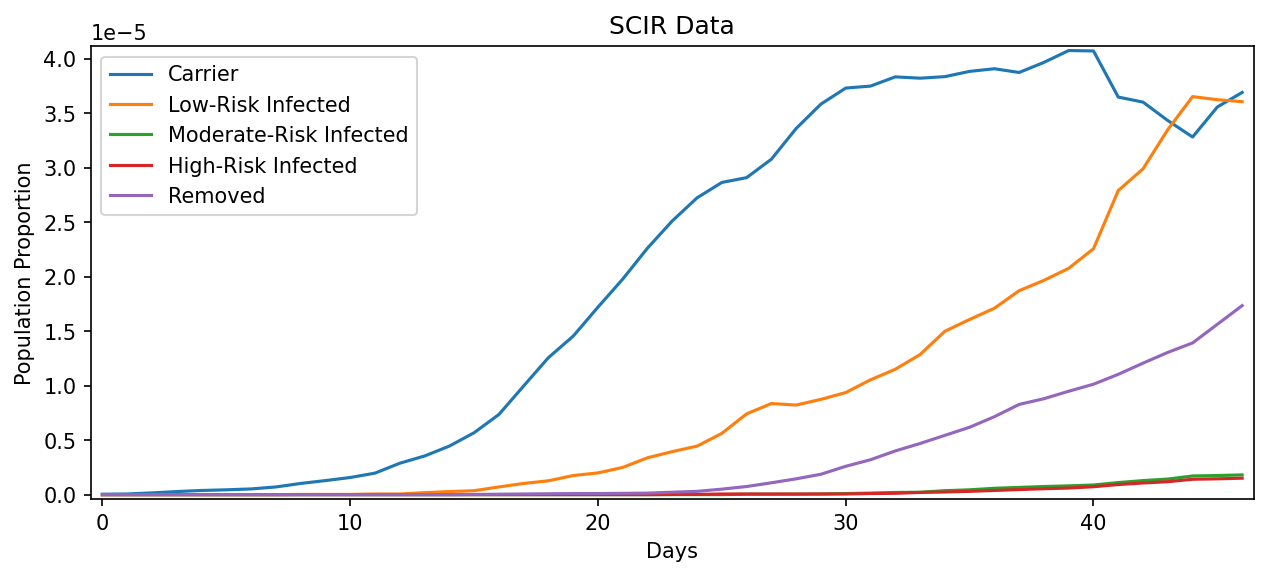

In [5]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('SCIR Data')
plt.plot(c,label="Carrier")
plt.plot(ic,label="Low-Risk Infected")
plt.plot(ih,label="Moderate-Risk Infected")
plt.plot(iu,label="High-Risk Infected")
plt.plot(r,label="Removed")
plt.margins(0.01, tight=True)
plt.xlabel("Days")
plt.ylabel("Population Proportion")
plt.legend()
print(end='')

In [16]:
# Define SINDy Model
sindy_model = ps.SINDy(
    differentiation_method=ps.FiniteDifference(),
    optimizer=ps.STLSQ(threshold=5e-9),
    feature_library=ps.PolynomialLibrary(degree=2),
    feature_names=['s', 'c', 'ic', 'ih', 'iu', 'r']
)

x_train = np.stack((s, c, ic, ih, iu, r), axis=-1)

# Fit model and get time taken
tic = time.time()
sindy_model.fit(x_train, quiet=True)
toc = time.time()
sindy_time = toc - tic

# Print resulting model
sindy_model.print()

# Simulate SINDy on the test data
sindy_sim = sindy_model.simulate(x_train[-1], t=len(s) + np.arange(100))

s' = 11931.399 1 + -23864.111 s + -6456.975 c + -17064.619 ic + 11932.712 s^2 + 6457.984 s c + 17066.255 s ic
c' = -3457.497 1 + 6915.247 s + 10801.887 ic + -3457.750 s^2 + -10802.718 s ic
ic' = 778.096 1 + -1555.914 s + -2024.929 c + -8287.486 ic + 777.818 s^2 + 2024.635 s c + 8287.866 s ic
ih' = 21.341 1 + -42.682 s + 21.341 s^2
iu' = 21.285 1 + -42.569 s + 21.285 s^2
r' = 352.976 1 + -705.980 s + -16.250 c + 353.004 s^2 + 16.279 s c


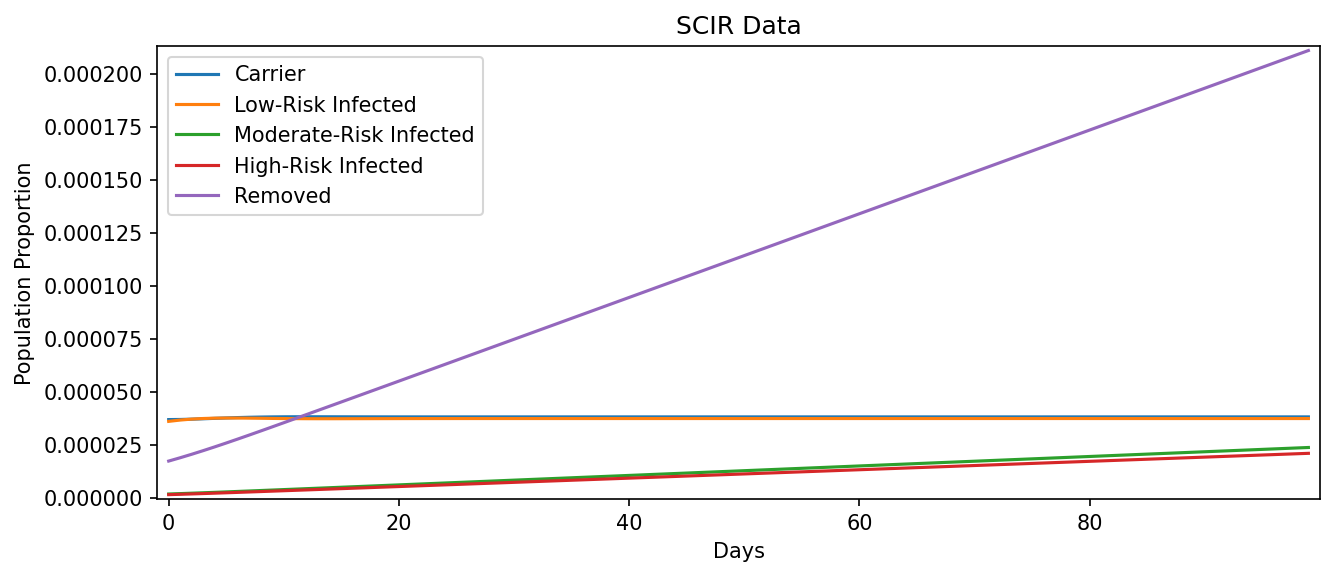

In [17]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('SCIR Data')
plt.plot(sindy_sim[:,1], label="Carrier")
plt.plot(sindy_sim[:,2], label="Low-Risk Infected")
plt.plot(sindy_sim[:,3], label="Moderate-Risk Infected")
plt.plot(sindy_sim[:,4], label="High-Risk Infected")
plt.plot(sindy_sim[:,5], label="Removed")
plt.margins(0.01, tight=True)
plt.xlabel("Days")
plt.ylabel("Population Proportion")
plt.legend()
print(end='')